In [577]:
import sys
import os

sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('')), '..'))

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [578]:
def transform_file(file : str, newfile : str, attacks : list):
     attack_dicts = { attack : { "Precision" : {}, "Recall" : {}, "AUROC" : {}, "AUPR" : {}, "FPR@95%TPR" : {}, "FPR" : {}, "TP_MMPS" : {}, "FP_MMPS" : {}, "FN_MMPS" : {}, "TN_MMPS" : {}} for attack in attacks}

     with open('../results/'+file+".json", 'r') as j:
          contents = json.loads(j.read())
          for i,c in enumerate(contents[0]): 
               dataset = c.split("_")[-1]
               value = format(contents[0][c],'.4f')
               for attack in attacks:
                    if attack in c:
                         if "precision" in c:
                              attack_dicts[attack]["Precision"][dataset] = value
                         if "recall" in c:
                              attack_dicts[attack]["Recall"][dataset] = value
                         if "auroc" in c:
                              attack_dicts[attack]["AUROC"][dataset] = value
                         if "aupr" in c:
                              attack_dicts[attack]["AUPR"][dataset] = value
                         if "auroc" in c:
                              attack_dicts[attack]["AUROC"][dataset] = value
                         if "fpr_at_tpr95" in c:
                              attack_dicts[attack]["FPR@95%TPR"][dataset] = value
                         if "fpr" in c:
                              attack_dicts[attack]["FPR"][dataset] = value
                         if "tp_mmps" in c:
                              attack_dicts[attack]["TP_MMPS"][dataset] = value
                         if "fp_mmps" in c:
                              attack_dicts[attack]["FP_MMPS"][dataset] = value
                         if "fn_mmps" in c:
                              attack_dicts[attack]["FN_MMPS"][dataset] = value
                         if "tn_mmps" in c:
                              attack_dicts[attack]["TN_MMPS"][dataset] = value
     dfs = []
     for attack in attacks:
          dfs.append(pd.DataFrame.from_dict(attack_dicts[attack]))
          dfs[-1].rename(columns=lambda x: attack + " " + x, inplace=True)
     df = pd.concat(dfs,axis=1)
     df.to_csv("../results/"+ newfile + "_attack_results.csv", encoding='utf-8')

In [579]:
def get_cleaned_dataframe(csv_file_path, metric):
    
    # read the csv file
    df = pd.read_csv(csv_file_path)

    # get only the relevant columns
    df = df[['Unnamed: 0', 'AugmentationAttack ' + metric, 'RandomNoiseAttack '+ metric,'DecisionBoundaryAttack ' + metric]]
    df.rename(columns={'Unnamed: 0': 'Dataset','AugmentationAttack ' + metric: 'Data Augmentation', 'RandomNoiseAttack ' + metric: 'Noise Robustness', 'DecisionBoundaryAttack '+ metric: 'Decision Boundary'}, inplace=True)
    df.index = df['Dataset'].values.tolist()

    df_ls = None
    df_llla = None
    try:
        file_ls = csv_file_path.replace("_attack","_LS_attack")
        df_ls = pd.read_csv(file_ls)
        df_ls = df_ls[['Unnamed: 0', 'AugmentationAttack ' + metric, 'RandomNoiseAttack ' + metric,'DecisionBoundaryAttack ' + metric]]
        df_ls.rename(columns={'Unnamed: 0': 'Dataset','AugmentationAttack ' + metric: 'Data Augmentation with LS', 'RandomNoiseAttack ' + metric: 'Noise Robustness with LS', 'DecisionBoundaryAttack '+ metric: 'Decision Boundary with LS'}, inplace=True)
        df_ls.index = df_ls['Dataset'].values.tolist()
        df_ls = df_ls.sort_values('Dataset',ascending=False)
    except Exception as e:
        pass
    try:
        file_llla = csv_file_path.replace("_attack","_LLLA_attack")
        df_llla = pd.read_csv(file_llla)
        df_llla = df_llla[['Unnamed: 0', 'AugmentationAttack ' + metric, 'RandomNoiseAttack ' + metric,'DecisionBoundaryAttack ' + metric]]
        df_llla.rename(columns={'Unnamed: 0': 'Dataset','AugmentationAttack ' + metric: 'Data Augmentation with LLLA', 'RandomNoiseAttack ' + metric: 'Noise Robustness with LLLA', 'DecisionBoundaryAttack '+ metric: 'Decision Boundary with LLLA'}, inplace=True)
        df_llla.index = df_llla['Dataset'].values.tolist()
        df_llla = df_llla.sort_values('Dataset',ascending=False)
    except Exception as e:
        pass

    return df, df_ls, df_llla

def plot_dataframe(model, metric, df1, df2, figsize=(20, 15)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.tick_params(axis='x', labelrotation=60, labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.yaxis.label.set_size(25)
    ax.yaxis.label.set_weight('bold')
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('bold')

    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('bold')
 
    ax.grid(True)
    plt.title(model.capitalize(), fontsize=24, fontweight="bold")
    #plt.subplots_adjust(bottom=0.35)        
    #plt.tight_layout()
    df2 = df2.set_index('Dataset')
    df2 = df2.loc[list(df.Dataset)]
    ax = sns.barplot(x="Dataset",y=metric,hue="Attack",alpha=1,data=df1,palette="tab10")
    ax = sns.barplot(x=df2.index,y=metric,hue="Attack",alpha=0.5,data=df2,palette="tab10",ci=None)
    ax.set(xlabel="")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc="best", prop={'weight':'bold', 'size':23}, frameon=True, labelspacing=0.05, borderpad=0.2, borderaxespad=0.0, framealpha=1, handletextpad=0.2)
    #plt.legend("")
    return ax

resnet18


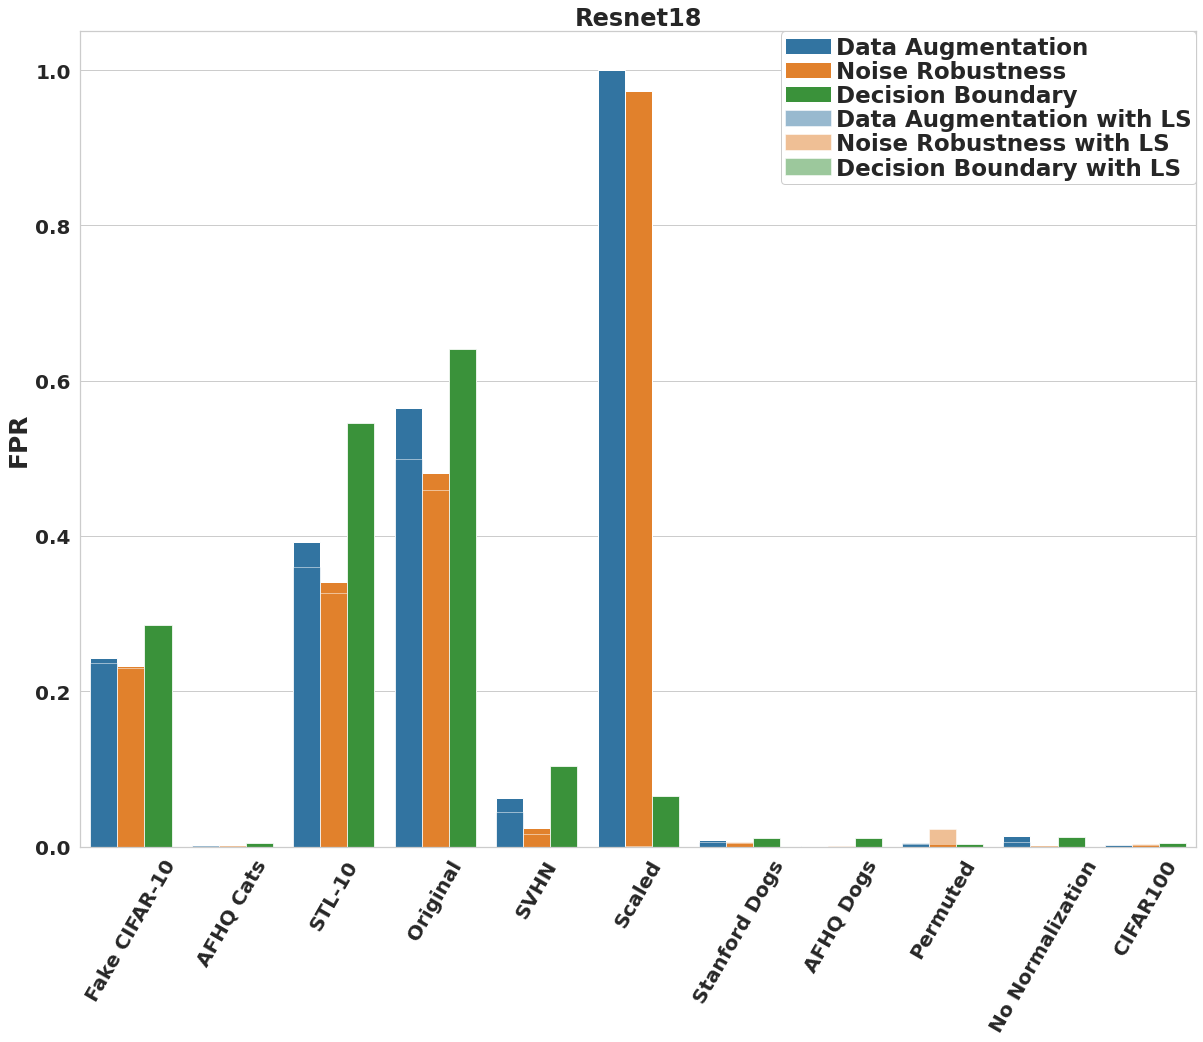

In [580]:
#transform_file("resnet18","resnet18",["AugmentationAttack","RandomNoiseAttack","DecisionBoundaryAttack"])
#transform_file("resnet18_LS","resnet18_LS",["AugmentationAttack","RandomNoiseAttack","DecisionBoundaryAttack"])

models = ["resnet18"]#,"salem_cnn_relu", "efficient_net", "efficient_net_LS"]
for model in models:
    print(model)
    df, df_ls, df_llla = get_cleaned_dataframe('../results/'+model+'_attack_results.csv', 'FPR')
    df = pd.melt(df, id_vars=['Dataset'], var_name='Attack', value_name='FPR')
    if df_ls is not None:
        df_ls = pd.melt(df_ls, id_vars=['Dataset'], var_name='Attack', value_name='FPR')
    ax = plot_dataframe(model, 'FPR', df, df_ls)
    fig = ax.get_figure()
    fig.savefig(model+'_attack_results_scores.pdf')